In [2]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Scaling

In [6]:
# Define your scaling function
def custom_scaling(input_values):
    input_values_scaled = np.zeros_like(input_values, dtype=float)  # Initialize scaled data array
    input_values_scaled[:, 0] = (input_values[:, 0] - L_min) / (L_max - L_min)  # Scale L
    input_values_scaled[:, 1] = (input_values[:, 1] - C_min) / (C_max - C_min)  # Scale C
    input_values_scaled[:, 2] = (input_values[:, 2] - fsw_min) / (fsw_max - fsw_min)  # Scale fsw
    input_values_scaled[:, 3] = (input_values[:, 3] - t_dt_min) / (t_dt_max - t_dt_min) # Scale t_dt
    return input_values_scaled

# Define your scaling function
def custom_scaling_1(input_values):
    input_values_scaled = np.zeros_like(input_values, dtype=float)  # Initialize scaled data array
    input_values_scaled[:, 0] = (input_values[:, 0] - L_min) / (L_max - L_min)  # Scale L
    input_values_scaled[:, 1] = (input_values[:, 1] - C_min) / (C_max - C_min)  # Scale C
    input_values_scaled[:, 2] = (input_values[:, 2] - fsw_min) / (fsw_max - fsw_min)  # Scale fsw
    # input_values_scaled[:, 3] = (input_values[:, 3] - t_dt_min) / (t_dt_max - t_dt_min) # Scale t_dt
    return input_values_scaled

# 4 input 7 output

## Search N and H

In [4]:


# Fix random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load your simulation data
# Replace "your_dataset.csv" with the path to your dataset
# df = pd.read_csv(r"D:\Krishna\ai-power-converter\dataset\simulation_results_13x13x13x13.csv")
df = pd.read_csv(r"D:\Krishna\ai-power-converter\simulation_results_new_20_20_20_20.csv")

# Extract input features (L, C, fsw)
X = df[['L', 'C', 'fsw', "t_dt"]].values

# Extract output (ripples)
y = df[["delta_current", "delta_voltage", "Pl_s1", "Pl_s2", "Pl_C", "Pl_L_Cu", "P_D"]].values  # Adjust column names as per your dataset

# Define custom scaling ranges for each input feature
L_min, L_max = 30e-6, 2000e-6
C_min, C_max = 20e-6, 1000e-6
fsw_min, fsw_max = 20e3, 200e3
t_dt_min, t_dt_max = 0.178e-6, 1e-6

X_scaled = custom_scaling(X)
print(X_scaled[90:])

# Split the dataset into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Define a custom callback to print custom information at the end of each epoch
class PrintEpochInfo(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch+1}/{self.params['epochs']}, Loss: {logs['loss']}, Val Loss: {logs['val_loss']}")


# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=1, mode='auto', restore_best_weights=True)

# Define the learning rate scheduler
lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-6)# Initialize a dictionary to store the training history for each configuration


histories = {}

# Initialize dictionaries to store the evaluation metrics for each configuration
mses = {}
maes = {}
rmses = {}
r2_scores = {}
mapes = {}

# Define a list of different values for H and Nh to try
H_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  # Number of hidden layers
Nh_values = [16, 32, 64, 128, 256, 512, 1024]  # Number of neurons per hidden layer

[[0.         0.01020408 0.21052222 0.52676399]
 [0.         0.01020408 0.21052222 0.57907543]
 [0.         0.01020408 0.21052222 0.63138686]
 ...
 [1.         0.18367347 1.         0.89416058]
 [1.         0.18367347 1.         0.94768856]
 [1.         0.18367347 1.         1.        ]]


Epoch 1/100, Loss: 1.9246611595153809, Val Loss: 1.2758673429489136
Epoch 2/100, Loss: 1.2792797088623047, Val Loss: 0.7990705370903015
Epoch 3/100, Loss: 1.1202971935272217, Val Loss: 0.7458369135856628
Epoch 4/100, Loss: 1.0749698877334595, Val Loss: 0.6917657852172852
Epoch 5/100, Loss: 1.0608856678009033, Val Loss: 0.7125511765480042
Epoch 6/100, Loss: 1.0439070463180542, Val Loss: 0.6502262353897095
Epoch 7/100, Loss: 1.0403363704681396, Val Loss: 0.6998559832572937
Epoch 8/100, Loss: 1.0276991128921509, Val Loss: 0.7439783811569214
Epoch 9/100, Loss: 1.0303202867507935, Val Loss: 0.6792675256729126
Epoch 10/100, Loss: 1.0157759189605713, Val Loss: 0.6413421630859375
Epoch 11/100, Loss: 1.0123485326766968, Val Loss: 0.6187499761581421
Epoch 12/100, Loss: 1.0172274112701416, Val Loss: 0.6546234488487244
Epoch 13/100, Loss: 1.0214985609054565, Val Loss: 0.7224487066268921
Epoch 14/100, Loss: 1.0106250047683716, Val Loss: 0.6207059621810913
Epoch 15/100, Loss: 1.006225824356079, Val 

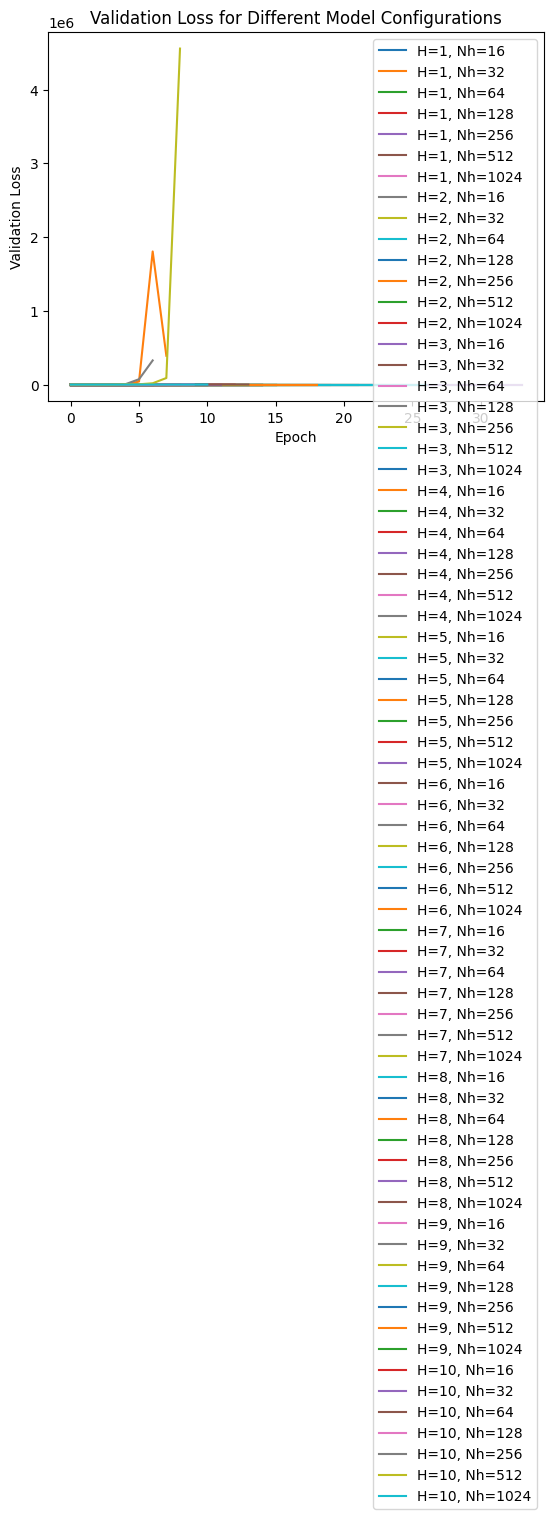

Model with H=1 and Nh=16:
MSE: 0.6265968084335327
MAE: 0.6265967038621006
RMSE: 4.066911395367891
R-squared: 0.8955285863241139
MAPE: 17.907965061773222%
Model with H=1 and Nh=32:
MSE: 0.6190970540046692
MAE: 0.6190972540102516
RMSE: 2.9397455427177785
R-squared: 0.9274537450970973
MAPE: 16.19143216080721%
Model with H=1 and Nh=64:
MSE: 0.5211517214775085
MAE: 0.5211517868389837
RMSE: 2.3811141792798383
R-squared: 0.9483135356150829
MAPE: 14.110040269276675%
Model with H=1 and Nh=128:
MSE: 0.4933047294616699
MAE: 0.49330505343714265
RMSE: 2.095916714663894
R-squared: 0.947496293681229
MAPE: 14.718506945916932%
Model with H=1 and Nh=256:
MSE: 0.435322642326355
MAE: 0.4353226992604551
RMSE: 1.9247939746480383
R-squared: 0.9763656947150536
MAPE: 12.218814356338726%
Model with H=1 and Nh=512:
MSE: 0.4233657121658325
MAE: 0.4233654101177021
RMSE: 2.003236027742635
R-squared: 0.9580745978570425
MAPE: 11.930948599224246%
Model with H=1 and Nh=1024:
MSE: 0.38290804624557495
MAE: 0.382908039038

In [4]:

# Iterate over different values of H and Nh
for H in H_values:
    for Nh in Nh_values:
        # Initialize a Sequential model
        model = tf.keras.Sequential()

        # Add the first hidden layer with batch normalization
        model.add(tf.keras.layers.Dense(Nh, activation='relu', input_shape=(4,)))  
        model.add(tf.keras.layers.BatchNormalization())

        # Add subsequent hidden layers with batch normalization
        for _ in range(H - 1):
            model.add(tf.keras.layers.Dense(Nh, activation='relu'))
            model.add(tf.keras.layers.BatchNormalization())

        # Output layer (assuming it follows the hidden layers)
        model.add(tf.keras.layers.Dense(7, activation='softplus'))  

        # Compile the model
        model.compile(optimizer='adam', loss='mean_absolute_error')

        # Train the model and store the training history
    # Train the model with given hyperparameters
        history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), 
                        callbacks=[PrintEpochInfo(), lr_scheduler, early_stopping], verbose=0)
    
        histories[(H, Nh)] = history

        # Evaluate the model on the testing set
        predictions = model.predict(X_test)

        # Evaluate the model on the testing set and calculate MSE
        mse = model.evaluate(X_test, y_test)
        mses[(H, Nh)] = mse

        # Calculate Mean Absolute Error (MAE)
        mae = mean_absolute_error(y_test, predictions)
        maes[(H, Nh)] = mae

        # Calculate Root Mean Squared Error (RMSE)
        rmse = np.sqrt(mean_squared_error(y_test, predictions))
        rmses[(H, Nh)] = rmse

        # Calculate R-squared (R2) Score
        r2 = r2_score(y_test, predictions)
        r2_scores[(H, Nh)] = r2

        # Calculate Mean Absolute Percentage Error (MAPE)
        mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100
        mapes[(H, Nh)] = mape

# Plot the validation loss for each configuration
for (H, Nh), history in histories.items():
    plt.plot(history.history['val_loss'], label=f'H={H}, Nh={Nh}')

plt.title('Validation Loss for Different Model Configurations')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()

# Print the MSE for each configuration
# Print the evaluation metrics for each configuration
for (H, Nh), mse in mses.items():
    print(f'Model with H={H} and Nh={Nh}:')
    print(f'MSE: {mse}')
    print(f'MAE: {maes[(H, Nh)]}')
    print(f'RMSE: {rmses[(H, Nh)]}')
    print(f'R-squared: {r2_scores[(H, Nh)]}')
    print(f'MAPE: {mapes[(H, Nh)]}%')


### Ranking

In [5]:
# Rank combinations based on their MSE values
ranked_combinations = sorted(mses.items(), key=lambda x: x[1])

# Print ranked combinations
for idx, ((H, Nh), mse) in enumerate(ranked_combinations, start=1):
    print(f"Rank {idx}: Combination H={H}, Nh={Nh} - MSE: {mse}")


Rank 1: Combination H=6, Nh=256 - MSE: 0.19650597870349884
Rank 2: Combination H=4, Nh=128 - MSE: 0.21628442406654358
Rank 3: Combination H=4, Nh=256 - MSE: 0.2414274513721466
Rank 4: Combination H=6, Nh=128 - MSE: 0.2559279501438141
Rank 5: Combination H=7, Nh=64 - MSE: 0.27813419699668884
Rank 6: Combination H=5, Nh=256 - MSE: 0.29665935039520264
Rank 7: Combination H=4, Nh=64 - MSE: 0.3053044378757477
Rank 8: Combination H=9, Nh=64 - MSE: 0.30768752098083496
Rank 9: Combination H=3, Nh=256 - MSE: 0.3080404996871948
Rank 10: Combination H=5, Nh=32 - MSE: 0.3107946515083313
Rank 11: Combination H=5, Nh=64 - MSE: 0.31213831901550293
Rank 12: Combination H=8, Nh=64 - MSE: 0.31386059522628784
Rank 13: Combination H=7, Nh=128 - MSE: 0.31882333755493164
Rank 14: Combination H=5, Nh=128 - MSE: 0.3205721974372864
Rank 15: Combination H=3, Nh=128 - MSE: 0.347360759973526
Rank 16: Combination H=5, Nh=512 - MSE: 0.3490273952484131
Rank 17: Combination H=4, Nh=512 - MSE: 0.3616322875022888
Rank 

Rank 1: Combination H=5, Nh=256 - MSE: 0.2685861587524414
Rank 2: Combination H=5, Nh=512 - MSE: 0.26927897334098816
Rank 3: Combination H=4, Nh=1024 - MSE: 0.2832221984863281
Rank 4: Combination H=4, Nh=512 - MSE: 0.29064759612083435
Rank 5: Combination H=6, Nh=1024 - MSE: 0.3075002133846283
Rank 6: Combination H=7, Nh=256 - MSE: 0.32315966486930847
Rank 7: Combination H=3, Nh=256 - MSE: 0.3244527578353882
Rank 8: Combination H=4, Nh=128 - MSE: 0.32607361674308777
Rank 9: Combination H=4, Nh=256 - MSE: 0.3269226551055908
Rank 10: Combination H=5, Nh=1024 - MSE: 0.33056139945983887
Rank 11: Combination H=4, Nh=64 - MSE: 0.3360600769519806
Rank 12: Combination H=3, Nh=512 - MSE: 0.3548477292060852
Rank 13: Combination H=7, Nh=128 - MSE: 0.36053985357284546
Rank 14: Combination H=6, Nh=64 - MSE: 0.36217623949050903
Rank 15: Combination H=3, Nh=1024 - MSE: 0.3668963313102722

In [6]:
# Specify the combination you want to call
H = 6
Nh = 256

# Retrieve the model for the specified combination
selected_model = histories[(H, Nh)].model
selected_model.save("model_6_256_20_20_20_20.h5")
# Use the trained model to make predictions on the testing set
predictions = selected_model.predict(X_test)

# Evaluate the model on the testing set
mse = selected_model.evaluate(X_test, y_test)
print("Mean Squared Error on Testing Set:", mse)

# Print the first few predictions
print("Predictions:")
print(predictions[:5])

# Print the corresponding true values
print("True Values:")
print(y_test[:5])

 62/750 [=>............................] - ETA: 0s

d:\Software\Python\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


750/750 [==============================] - 1s 819us/step - loss: 0.1965
Mean Squared Error on Testing Set: 0.19650597870349884
Predictions:
[[1.0219637e+01 4.5056027e-01 1.6853890e+00 1.6735905e+00 6.7400590e-02
  1.5987738e+00 6.8811283e-02]
 [0.0000000e+00 1.7507122e-07 1.4677124e+00 1.4832344e+00 3.5829239e-03
  3.9988381e-01 1.2376591e-01]
 [7.4750261e+00 6.6595018e-01 1.7110184e+00 1.7082503e+00 5.5595353e-02
  1.6504406e+00 6.1348688e-02]
 [8.0876646e+00 2.6589451e+00 2.5022225e+00 2.4939084e+00 1.6155841e-02
  1.0894253e+00 5.4000672e-02]
 [1.5769609e+01 7.3881488e+00 1.6915892e+00 1.6767877e+00 9.1617201e-03
  6.3844192e-01 1.0877731e-01]]
True Values:
[[1.03131378e+01 4.13992151e-01 1.68153236e+00 1.68153236e+00
  7.19429836e-02 1.63623509e+00 6.50622125e-02]
 [1.57412647e+00 5.88833103e-01 1.55288744e+00 1.55288744e+00
  7.44111990e-03 4.64687549e-01 1.37156431e-01]
 [7.26807243e+00 7.49825031e-01 1.70935463e+00 1.70935463e+00
  5.27434900e-02 1.69007496e+00 5.96008677e-02]
 

# Split Dataset

 ## Delta current

In [5]:


# Fix random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load your simulation data
# Replace "your_dataset.csv" with the path to your dataset
# df = pd.read_csv(r"D:\Krishna\ai-power-converter\dataset\simulation_results_23x13x13x13.csv")
# df_1 = pd.read_csv(r"D:\Krishna\ai-power-converter\simulation_results_new_20_20_20_20.csv")
df_1 = pd.read_csv(r"E:\ai-power-converter\simulation_results_new_20_20_20_20.csv")

# Extract input features (L, C, fsw)
X_1 = df_1[['L', 'C', 'fsw', "t_dt"]].values

# Extract output (ripples)
y_1 = df_1[["delta_current"]].values  # Adjust column names as per your dataset

scaler_y_dynamic = MinMaxScaler(feature_range=(0, 1))


# Fit the scaler to your target variable and transform it
y_scaled_dynamic = scaler_y_dynamic.fit_transform(y_1)

# Define custom scaling ranges for each input feature
L_min, L_max = 30e-6, 2000e-6
C_min, C_max = 20e-6, 1000e-6
fsw_min, fsw_max = 20e3, 200e3
t_dt_min, t_dt_max = 0.178e-6, 1e-6

X_scaled_1 = custom_scaling(X_1)
# print(X_scaled_1[90:])

# Split the dataset into training, validation, and testing sets
X_train_1, X_temp_1, y_train_1, y_temp_1 = train_test_split(X_scaled_1, y_scaled_dynamic, test_size=0.3, random_state=42)
X_val_1, X_test_1, y_val_1, y_test_1 = train_test_split(X_temp_1, y_temp_1, test_size=0.5, random_state=42)

# Define a custom callback to print custom information at the end of each epoch
class PrintEpochInfo(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch+1}/{self.params['epochs']}, Loss: {logs['loss']}, Val Loss: {logs['val_loss']}")


# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=1, mode='auto', restore_best_weights=True)

# Define the learning rate scheduler
lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-6)# Initialize a dictionary to store the training history for each configuration


histories_1 = {}

# Initialize dictionaries to store the evaluation metrics for each configuration
mses_1 = {}
maes_1 = {}
rmses_1 = {}
r2_scores_1 = {}
mapes_1 = {}

# Define a list of different values for H and Nh to try
H_values = [1, 2, 3, 4, 5, 6]  # Number of hidden layers
Nh_values = [16, 32, 64, 128, 256]  # Number of neurons per hidden layer

NameError: name 'custom_scaling' is not defined

In [9]:
# Determine the minimum and maximum values for y
y_min = np.min(y_1)
y_max = np.max(y_1)

# Define the feature range based on the computed min and max values
y_min_range = y_min - (0.1 * np.abs(y_min))  # Adjust the range if needed
y_max_range = y_max + (0.1 * np.abs(y_max))  # Adjust the range if needed

# Initialize the scaler for y values using the computed range
scaler_y_dynamic = MinMaxScaler(feature_range=(0, 1))

print("ori: ", y_1[:5])
# Fit the scaler to your target variable and transform it
y_scaled_dynamic = scaler_y_dynamic.fit_transform(y_1)
print("scaled: ", y_scaled_dynamic[:5])


inverse_y_scaled_dynamic = scaler_y_dynamic.inverse_transform(y_scaled_dynamic)
print("inverse:", inverse_y_scaled_dynamic)


ori:  [[630.73654602]
 [631.69964546]
 [615.84332538]
 [627.52116206]
 [631.48715761]]
scaled:  [[0.76776861]
 [0.76894294]
 [0.74960897]
 [0.76384802]
 [0.76868385]]
inverse: [[630.73654602]
 [631.69964546]
 [615.84332538]
 ...
 [ 17.26134943]
 [ 17.25770754]
 [ 17.28823085]]


Epoch 1/100, Loss: 10.13820743560791, Val Loss: 6.178614139556885
Epoch 2/100, Loss: 6.9469380378723145, Val Loss: 3.968931198120117
Epoch 3/100, Loss: 6.301599979400635, Val Loss: 3.6558570861816406
Epoch 4/100, Loss: 6.023103713989258, Val Loss: 4.074254035949707
Epoch 5/100, Loss: 5.983500003814697, Val Loss: 3.8732385635375977
Epoch 6/100, Loss: 5.884448528289795, Val Loss: 3.2843339443206787
Epoch 7/100, Loss: 5.896140098571777, Val Loss: 3.680513620376587
Epoch 8/100, Loss: 5.831191539764404, Val Loss: 4.318524360656738
Epoch 9/100, Loss: 5.860747337341309, Val Loss: 3.6831448078155518
Epoch 10/100, Loss: 5.762189865112305, Val Loss: 3.221677303314209
Epoch 11/100, Loss: 5.744593620300293, Val Loss: 3.273277759552002
Epoch 12/100, Loss: 5.778689861297607, Val Loss: 3.680980682373047
Epoch 13/100, Loss: 5.816556930541992, Val Loss: 3.9250223636627197
Epoch 14/100, Loss: 5.733253002166748, Val Loss: 3.345128297805786
Epoch 15/100, Loss: 5.725317001342773, Val Loss: 3.75235748291015

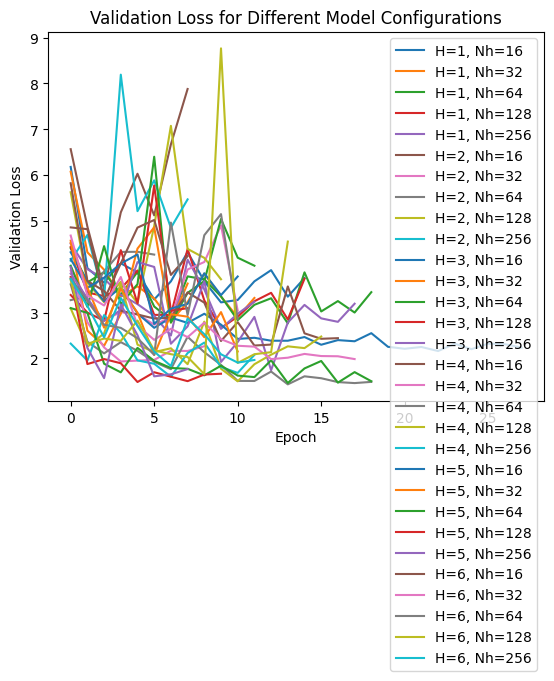

Model with H=1 and Nh=16:
MSE: 3.2907774448394775
MAE: 3.2907783724194344
RMSE: 8.190701270458735
R-squared: 0.9637727198957151
MAPE: 36.23236536814736%
Model with H=1 and Nh=32:
MSE: 2.8398091793060303
MAE: 2.839808668244751
RMSE: 7.975694131791839
R-squared: 0.9656496998386347
MAPE: 32.332479557744165%
Model with H=1 and Nh=64:
MSE: 2.7659146785736084
MAE: 2.76591444771659
RMSE: 5.391377755444788
R-squared: 0.9843038521673239
MAPE: 36.90860945020514%
Model with H=1 and Nh=128:
MSE: 2.671079635620117
MAE: 2.6710800479247983
RMSE: 5.293414192532851
R-squared: 0.9848690808571067
MAPE: 36.052974400739544%
Model with H=1 and Nh=256:
MSE: 2.545590400695801
MAE: 2.545591657519643
RMSE: 5.61416300221521
R-squared: 0.9829798418487341
MAPE: 29.652469663946068%
Model with H=2 and Nh=16:
MSE: 3.562988042831421
MAE: 3.5629907938644374
RMSE: 10.798647690998402
R-squared: 0.9370302019611932
MAPE: 28.551714797631483%
Model with H=2 and Nh=32:
MSE: 2.727264881134033
MAE: 2.727263948736594
RMSE: 6.572

In [13]:

# Iterate over different values of H and Nh
for H in H_values:
    for Nh in Nh_values:
        # Initialize a Sequential model
        model_1 = tf.keras.Sequential()

        # Add the first hidden layer with batch normalization
        model_1.add(tf.keras.layers.Dense(Nh, activation='relu', input_shape=(4,)))  
        model_1.add(tf.keras.layers.BatchNormalization())

        # Add subsequent hidden layers with batch normalization
        for _ in range(H - 1):
            model_1.add(tf.keras.layers.Dense(Nh, activation='relu'))
            model_1.add(tf.keras.layers.BatchNormalization())

        # Output layer (assuming it follows the hidden layers)
        model_1.add(tf.keras.layers.Dense(1, activation='softplus'))  

        # Compile the model
        model_1.compile(optimizer='adam', loss='mean_absolute_error')

        # Train the model and store the training history
    # Train the model with given hyperparameters
        history_1 = model_1.fit(X_train_1, y_train_1, epochs=100, batch_size=32, validation_data=(X_val_1, y_val_1), 
                        callbacks=[PrintEpochInfo(), lr_scheduler, early_stopping], verbose=0)
    
        histories_1[(H, Nh)] = history_1

        # Evaluate the model on the testing set
        predictions_1 = model_1.predict(X_test_1)

        # Evaluate the model on the testing set and calculate MSE
        mse_1 = model_1.evaluate(X_test_1, y_test_1)
        mses_1[(H, Nh)] = mse_1

        # Calculate Mean Absolute Error (MAE)
        mae_1 = mean_absolute_error(y_test_1, predictions_1)
        maes_1[(H, Nh)] = mae_1

        # Calculate Root Mean Squared Error (RMSE)
        rmse_1 = np.sqrt(mean_squared_error(y_test_1, predictions_1))
        rmses_1[(H, Nh)] = rmse_1

        # Calculate R-squared (R2) Score
        r2_1 = r2_score(y_test_1, predictions_1)
        r2_scores_1[(H, Nh)] = r2_1

        # Calculate Mean Absolute Percentage Error (MAPE)
        mape_1 = np.mean(np.abs((y_test_1 - predictions_1) / y_test_1)) * 100
        mapes_1[(H, Nh)] = mape_1

# Plot the validation loss for each configuration
for (H, Nh), history_1 in histories_1.items():
    plt.plot(history_1.history['val_loss'], label=f'H={H}, Nh={Nh}')

plt.title('Validation Loss for Different Model Configurations')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()

# Print the MSE for each configuration
# Print the evaluation metrics for each configuration
for (H, Nh), mse_1 in mses_1.items():
    print(f'Model with H={H} and Nh={Nh}:')
    print(f'MSE: {mse_1}')
    print(f'MAE: {maes_1[(H, Nh)]}')
    print(f'RMSE: {rmses_1[(H, Nh)]}')
    print(f'R-squared: {r2_scores_1[(H, Nh)]}')
    print(f'MAPE: {mapes_1[(H, Nh)]}%')


In [14]:
# Rank combinations based on their MSE values
ranked_combinations_1 = sorted(mses_1.items(), key=lambda x: x[1])

# Print ranked combinations
for idx, ((H, Nh), mse_1) in enumerate(ranked_combinations_1, start=1):
    print(f"Rank {idx}: Combination H={H}, Nh={Nh} - MSE: {mse_1}")


Rank 1: Combination H=4, Nh=64 - MSE: 1.4519739151000977
Rank 2: Combination H=5, Nh=128 - MSE: 1.5099642276763916
Rank 3: Combination H=4, Nh=128 - MSE: 1.5163413286209106
Rank 4: Combination H=5, Nh=64 - MSE: 1.5180816650390625
Rank 5: Combination H=5, Nh=256 - MSE: 1.6238746643066406
Rank 6: Combination H=4, Nh=256 - MSE: 1.641098141670227
Rank 7: Combination H=6, Nh=128 - MSE: 1.6627451181411743
Rank 8: Combination H=3, Nh=256 - MSE: 1.755350947380066
Rank 9: Combination H=6, Nh=256 - MSE: 1.8676903247833252
Rank 10: Combination H=4, Nh=32 - MSE: 1.9616609811782837
Rank 11: Combination H=6, Nh=32 - MSE: 2.00762677192688
Rank 12: Combination H=6, Nh=64 - MSE: 2.022386312484741
Rank 13: Combination H=5, Nh=32 - MSE: 2.073518753051758
Rank 14: Combination H=3, Nh=16 - MSE: 2.221694231033325
Rank 15: Combination H=3, Nh=32 - MSE: 2.2951600551605225
Rank 16: Combination H=4, Nh=16 - MSE: 2.3150205612182617
Rank 17: Combination H=1, Nh=256 - MSE: 2.545590400695801
Rank 18: Combination H=

In [15]:
# Specify the combination you want to call
H = 4
Nh = 64

# Retrieve the model for the specified combination
selected_model_1 = histories_1[(H, Nh)].model
selected_model_1.save("model_4_64_delta_current.h5")
# Use the trained model to make predictions on the testing set
prediction_1 = selected_model_1.predict(X_test_1)
inverse_prediction = scaler_y_dynamic.inverse_transform(prediction_1)
# print("inverse:", inverse_prediction)

# Evaluate the model on the testing set
mse_1_1 = selected_model_1.evaluate(X_test_1, y_test_1)
print("Mean Squared Error on Testing Set:", mse_1_1)

# Print the first few predictions
print("Predictions:")
print(prediction_1[:5])

print("Inverse Predictions:")
print(inverse_prediction[:5])

# Print the corresponding true values
print("True Values:")
print(y_test[:5])

179/750 [======>.......................] - ETA: 0s

d:\Software\Python\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


750/750 [==============================] - 0s 557us/step - loss: 1.4520
Mean Squared Error on Testing Set: 1.4519739151000977
Predictions:
[[ 9.8106165]
 [ 0.       ]
 [ 7.517338 ]
 [ 8.527072 ]
 [18.32385  ]]
True Values:
[[10.31313779]
 [ 1.57412647]
 [ 7.26807243]
 [ 7.08448658]
 [15.36642696]]


## Delta voltage

In [16]:


# Fix random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load your simulation data
# Replace "your_dataset.csv" with the path to your dataset
# df = pd.read_csv(r"D:\Krishna\ai-power-converter\dataset\simulation_results_23x13x13x13.csv")
df_2 = pd.read_csv(r"D:\Krishna\ai-power-converter\simulation_results_new_20_20_20_20.csv")

# Extract input features (L, C, fsw)
X_2 = df_2[['L', 'C', 'fsw', "t_dt"]].values

# Extract output (ripples)
y_2 = df_2[["delta_voltage"]].values  # Adjust column names as per your dataset

# Define custom scaling ranges for each input feature
L_min, L_max = 30e-6, 2000e-6
C_min, C_max = 20e-6, 1000e-6
fsw_min, fsw_max = 20e3, 200e3
t_dt_min, t_dt_max = 0.178e-6, 1e-6

X_scaled = custom_scaling(X)
print(X_scaled[90:])

# Split the dataset into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y_2, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Define a custom callback to print custom information at the end of each epoch
class PrintEpochInfo(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch+1}/{self.params['epochs']}, Loss: {logs['loss']}, Val Loss: {logs['val_loss']}")


# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=1, mode='auto', restore_best_weights=True)

# Define the learning rate scheduler
lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-6)# Initialize a dictionary to store the training history for each configuration


histories_2 = {}

# Initialize dictionaries to store the evaluation metrics for each configuration
mses_2 = {}
maes_2 = {}
rmses_2 = {}
r2_scores_2 = {}
mapes_2 = {}

# Define a list of different values for H and Nh to try
H_values = [1, 2, 3, 4, 5, 6]  # Number of hidden layers
Nh_values = [16, 32, 64, 128, 256]  # Number of neurons per hidden layer

[[0.         0.01020408 0.21052222 0.52676399]
 [0.         0.01020408 0.21052222 0.57907543]
 [0.         0.01020408 0.21052222 0.63138686]
 ...
 [1.         0.18367347 1.         0.89416058]
 [1.         0.18367347 1.         0.94768856]
 [1.         0.18367347 1.         1.        ]]


Epoch 1/100, Loss: 1.1027427911758423, Val Loss: 0.7629654407501221
Epoch 2/100, Loss: 0.8009239435195923, Val Loss: 0.6534324884414673
Epoch 3/100, Loss: 0.7487207055091858, Val Loss: 0.6197011470794678
Epoch 4/100, Loss: 0.7146536707878113, Val Loss: 0.6067281365394592
Epoch 5/100, Loss: 0.719660222530365, Val Loss: 0.5959994196891785
Epoch 6/100, Loss: 0.7150020003318787, Val Loss: 0.5915926098823547
Epoch 7/100, Loss: 0.7125412225723267, Val Loss: 0.5973322987556458
Epoch 8/100, Loss: 0.708304762840271, Val Loss: 0.6295661330223083
Epoch 9/100, Loss: 0.7091710567474365, Val Loss: 0.6050588488578796
Epoch 10/100, Loss: 0.7041788697242737, Val Loss: 0.5939095616340637
Epoch 11/100, Loss: 0.7014192938804626, Val Loss: 0.6068564653396606
Restoring model weights from the end of the best epoch: 6.
Epoch 11: early stopping
750/750 [==============================] - 0s 495us/step - loss: 0.5904
Epoch 1/100, Loss: 1.1970094442367554, Val Loss: 0.9859197735786438
Epoch 2/100, Loss: 0.9873129

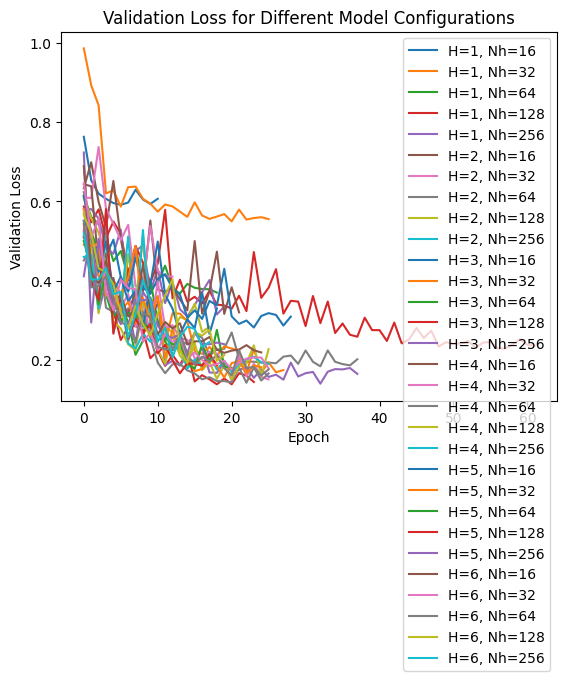

Model with H=1 and Nh=16:
MSE: 0.5904135704040527
MAE: 0.5904136491089836
RMSE: 1.0247138928033308
R-squared: 0.895530163634352
MAPE: 20.204884362924165%
Model with H=1 and Nh=32:
MSE: 0.5492957234382629
MAE: 0.5492959666284801
RMSE: 0.9830900790776603
R-squared: 0.9038449069034962
MAPE: 18.54772116900369%
Model with H=1 and Nh=64:
MSE: 0.36413827538490295
MAE: 0.3641381798903432
RMSE: 0.5866604696236692
R-squared: 0.9657579847007474
MAPE: 13.923078901396183%
Model with H=1 and Nh=128:
MSE: 0.22737237811088562
MAE: 0.22737237643631616
RMSE: 0.39409746247266386
R-squared: 0.9845477066993714
MAPE: 9.738887496251223%
Model with H=1 and Nh=256:
MSE: 0.30777814984321594
MAE: 0.3077780416885901
RMSE: 0.5215645402234564
R-squared: 0.9729353895653939
MAPE: 11.726638401565284%
Model with H=2 and Nh=16:
MSE: 0.31115415692329407
MAE: 0.3111541664417241
RMSE: 0.5046473764955914
R-squared: 0.9746626199603934
MAPE: 13.049421413319342%
Model with H=2 and Nh=32:
MSE: 0.38295918703079224
MAE: 0.3829591

In [18]:

# Iterate over different values of H and Nh
for H in H_values:
    for Nh in Nh_values:
        # Initialize a Sequential model
        model_2 = tf.keras.Sequential()

        # Add the first hidden layer with batch normalization
        model_2.add(tf.keras.layers.Dense(Nh, activation='relu', input_shape=(4,)))  
        model_2.add(tf.keras.layers.BatchNormalization())

        # Add subsequent hidden layers with batch normalization
        for _ in range(H - 1):
            model_2.add(tf.keras.layers.Dense(Nh, activation='relu'))
            model_2.add(tf.keras.layers.BatchNormalization())

        # Output layer (assuming it follows the hidden layers)
        model_2.add(tf.keras.layers.Dense(1, activation='softplus'))  

        # Compile the model
        model_2.compile(optimizer='adam', loss='mean_absolute_error')

        # Train the model and store the training history
    # Train the model with given hyperparameters
        history_2 = model_2.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), 
                        callbacks=[PrintEpochInfo(), lr_scheduler, early_stopping], verbose=0)
    
        histories_2[(H, Nh)] = history_2

        # Evaluate the model on the testing set
        predictions_2 = model_2.predict(X_test)

        # Evaluate the model on the testing set and calculate MSE
        mse_2 = model_2.evaluate(X_test, y_test)
        mses_2[(H, Nh)] = mse_2

        # Calculate Mean Absolute Error (MAE)
        mae_2 = mean_absolute_error(y_test, predictions_2)
        maes_2[(H, Nh)] = mae_2

        # Calculate Root Mean Squared Error (RMSE)
        rmse_2 = np.sqrt(mean_squared_error(y_test, predictions_2))
        rmses_2[(H, Nh)] = rmse_2

        # Calculate R-squared (R2) Score
        r2_2 = r2_score(y_test, predictions_2)
        r2_scores_2[(H, Nh)] = r2_2

        # Calculate Mean Absolute Percentage Error (MAPE)
        mape_2 = np.mean(np.abs((y_test - predictions_2) / y_test)) * 100
        mapes_2[(H, Nh)] = mape_2

# Plot the validation loss for each configuration
for (H, Nh), history_2 in histories_2.items():
    plt.plot(history_2.history['val_loss'], label=f'H={H}, Nh={Nh}')

plt.title('Validation Loss for Different Model Configurations')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()

# Print the MSE for each configuration
# Print the evaluation metrics for each configuration
for (H, Nh), mse_2 in mses_2.items():
    print(f'Model with H={H} and Nh={Nh}:')
    print(f'MSE: {mse_2}')
    print(f'MAE: {maes_2[(H, Nh)]}')
    print(f'RMSE: {rmses_2[(H, Nh)]}')
    print(f'R-squared: {r2_scores_2[(H, Nh)]}')
    print(f'MAPE: {mapes_2[(H, Nh)]}%')


In [19]:
# Rank combinations based on their MSE values
ranked_combinations_2 = sorted(mses_2.items(), key=lambda x: x[1])

# Print ranked combinations
for idx, ((H, Nh), mse_2) in enumerate(ranked_combinations_2, start=1):
    print(f"Rank {idx}: Combination H={H}, Nh={Nh} - MSE: {mse_2}")


Rank 1: Combination H=3, Nh=256 - MSE: 0.13269250094890594
Rank 2: Combination H=3, Nh=128 - MSE: 0.13835632801055908
Rank 3: Combination H=4, Nh=64 - MSE: 0.14478321373462677
Rank 4: Combination H=4, Nh=128 - MSE: 0.1465151458978653
Rank 5: Combination H=4, Nh=32 - MSE: 0.14960145950317383
Rank 6: Combination H=5, Nh=32 - MSE: 0.15517769753932953
Rank 7: Combination H=6, Nh=64 - MSE: 0.1579950600862503
Rank 8: Combination H=5, Nh=128 - MSE: 0.1643436849117279
Rank 9: Combination H=4, Nh=256 - MSE: 0.1654803305864334
Rank 10: Combination H=3, Nh=32 - MSE: 0.16820137202739716
Rank 11: Combination H=6, Nh=32 - MSE: 0.17596885561943054
Rank 12: Combination H=5, Nh=64 - MSE: 0.17894093692302704
Rank 13: Combination H=6, Nh=128 - MSE: 0.18263009190559387
Rank 14: Combination H=2, Nh=64 - MSE: 0.18419745564460754
Rank 15: Combination H=5, Nh=256 - MSE: 0.20379707217216492
Rank 16: Combination H=6, Nh=256 - MSE: 0.20491929352283478
Rank 17: Combination H=3, Nh=64 - MSE: 0.21376800537109375
Ra

In [20]:
# Specify the combination you want to call
H = 3
Nh = 256

# Retrieve the model for the specified combination
selected_model_2 = histories_2[(H, Nh)].model
selected_model_2.save("model_3_256_delta_voltage.h5")
# Use the trained model to make predictions on the testing set
prediction_2 = selected_model_2.predict(X_test)

# Evaluate the model on the testing set
mse_2_2 = selected_model_2.evaluate(X_test, y_test)
print("Mean Squared Error on Testing Set:", mse_2_2)

# Print the first few predictions
print("Predictions:")
print(prediction_2[:5])

# Print the corresponding true values
print("True Values:")
print(y_test[:5])

154/750 [=====>........................] - ETA: 0s

d:\Software\Python\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


750/750 [==============================] - 1s 673us/step - loss: 0.1327
Mean Squared Error on Testing Set: 0.13269250094890594
Predictions:
[[0.47405878]
 [0.01007675]
 [0.7433434 ]
 [2.8565638 ]
 [7.7655215 ]]
True Values:
[[0.41399215]
 [0.5888331 ]
 [0.74982503]
 [2.85925887]
 [7.91764236]]


## Pl_s1, Pl_s2

In [21]:


# Fix random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load your simulation data
# Replace "your_dataset.csv" with the path to your dataset
# df = pd.read_csv(r"D:\Krishna\ai-power-converter\dataset\simulation_results_33x13x13x13.csv")
df_3 = pd.read_csv(r"D:\Krishna\ai-power-converter\simulation_results_new_20_20_20_20.csv")

# Extract input features (L, C, fsw)
X_3 = df_3[['L', 'C', 'fsw', "t_dt"]].values

# Extract output (ripples)
y_3 = df_3[["Pl_s1", "Pl_s2"]].values  # Adjust column names as per your dataset

# Define custom scaling ranges for each input feature
L_min, L_max = 30e-6, 2000e-6
C_min, C_max = 20e-6, 1000e-6
fsw_min, fsw_max = 20e3, 200e3
t_dt_min, t_dt_max = 0.178e-6, 1e-6

X_scaled = custom_scaling(X)
print(X_scaled[90:])

# Split the dataset into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y_3, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Define a custom callback to print custom information at the end of each epoch
class PrintEpochInfo(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch+1}/{self.params['epochs']}, Loss: {logs['loss']}, Val Loss: {logs['val_loss']}")


# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=1, mode='auto', restore_best_weights=True)

# Define the learning rate scheduler
lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-6)# Initialize a dictionary to store the training history for each configuration


histories_3 = {}

# Initialize dictionaries to store the evaluation metrics for each configuration
mses_3 = {}
maes_3 = {}
rmses_3 = {}
r2_scores_3 = {}
mapes_3 = {}

# Define a list of different values for H and Nh to try
H_values = [1, 2, 3, 4, 5, 6]  # Number of hidden layers
Nh_values = [16, 32, 64, 128, 256]  # Number of neurons per hidden layer

[[0.         0.01020408 0.21052222 0.52676399]
 [0.         0.01020408 0.21052222 0.57907543]
 [0.         0.01020408 0.21052222 0.63138686]
 ...
 [1.         0.18367347 1.         0.89416058]
 [1.         0.18367347 1.         0.94768856]
 [1.         0.18367347 1.         1.        ]]


Epoch 1/100, Loss: 0.1673121303319931, Val Loss: 0.05998029187321663
Epoch 2/100, Loss: 0.09054559469223022, Val Loss: 0.062283407896757126
Epoch 3/100, Loss: 0.08715369552373886, Val Loss: 0.05596397817134857
Epoch 4/100, Loss: 0.08322587609291077, Val Loss: 0.06475479900836945
Epoch 5/100, Loss: 0.08250002562999725, Val Loss: 0.06680665910243988
Epoch 6/100, Loss: 0.08107909560203552, Val Loss: 0.07236340641975403
Epoch 7/100, Loss: 0.07918636500835419, Val Loss: 0.04807404428720474
Epoch 8/100, Loss: 0.07854965329170227, Val Loss: 0.04631536453962326
Epoch 9/100, Loss: 0.07816928625106812, Val Loss: 0.042831726372241974
Epoch 10/100, Loss: 0.07889598608016968, Val Loss: 0.05901142954826355
Epoch 11/100, Loss: 0.07729027420282364, Val Loss: 0.04178808256983757
Epoch 12/100, Loss: 0.0765664130449295, Val Loss: 0.051753055304288864
Epoch 13/100, Loss: 0.07695221155881882, Val Loss: 0.04676142334938049
Epoch 14/100, Loss: 0.07713425159454346, Val Loss: 0.0592944398522377
Epoch 15/100, L

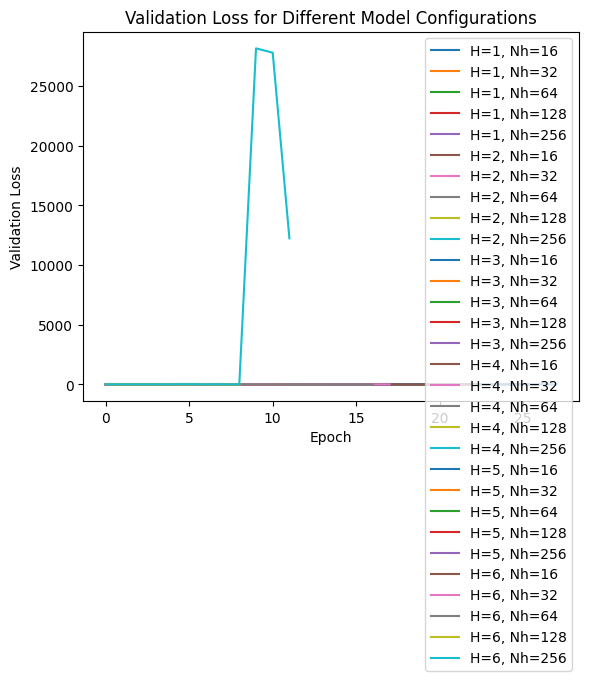

Model with H=1 and Nh=16:
MSE: 0.0412931889295578
MAE: 0.041293183349502605
RMSE: 0.06457140974244403
R-squared: 0.9748021320627264
MAPE: 2.225900335337124%
Model with H=1 and Nh=32:
MSE: 0.038778599351644516
MAE: 0.038778595065803445
RMSE: 0.055220905769581476
R-squared: 0.9815714862490785
MAPE: 2.0486036845832123%
Model with H=1 and Nh=64:
MSE: 0.03194533661007881
MAE: 0.03194535816173684
RMSE: 0.047739573640953846
R-squared: 0.9862266262919217
MAPE: 1.6377921121279986%
Model with H=1 and Nh=128:
MSE: 0.02563197910785675
MAE: 0.02563196336247319
RMSE: 0.03922904918981386
R-squared: 0.9906996600509901
MAPE: 1.3210530949882247%
Model with H=1 and Nh=256:
MSE: 0.02706291899085045
MAE: 0.027062923526049068
RMSE: 0.045697723824999696
R-squared: 0.9873796210240374
MAPE: 1.390124044157014%
Model with H=2 and Nh=16:
MSE: 0.03884532302618027
MAE: 0.03884533471368832
RMSE: 0.05687080915063141
R-squared: 0.9804538118964475
MAPE: 2.02941854951899%
Model with H=2 and Nh=32:
MSE: 0.021946663036942

In [22]:

# Iterate over different values of H and Nh
for H in H_values:
    for Nh in Nh_values:
        # Initialize a Sequential model
        model_3 = tf.keras.Sequential()

        # Add the first hidden layer with batch normalization
        model_3.add(tf.keras.layers.Dense(Nh, activation='relu', input_shape=(4,)))  
        model_3.add(tf.keras.layers.BatchNormalization())

        # Add subsequent hidden layers with batch normalization
        for _ in range(H - 1):
            model_3.add(tf.keras.layers.Dense(Nh, activation='relu'))
            model_3.add(tf.keras.layers.BatchNormalization())

        # Output layer (assuming it follows the hidden layers)
        model_3.add(tf.keras.layers.Dense(2, activation='softplus'))  

        # Compile the model
        model_3.compile(optimizer='adam', loss='mean_absolute_error')

        # Train the model and store the training history
    # Train the model with given hyperparameters
        history_3 = model_3.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), 
                        callbacks=[PrintEpochInfo(), lr_scheduler, early_stopping], verbose=0)
    
        histories_3[(H, Nh)] = history_3

        # Evaluate the model on the testing set
        predictions_3 = model_3.predict(X_test)

        # Evaluate the model on the testing set and calculate MSE
        mse_3 = model_3.evaluate(X_test, y_test)
        mses_3[(H, Nh)] = mse_3

        # Calculate Mean Absolute Error (MAE)
        mae_3 = mean_absolute_error(y_test, predictions_3)
        maes_3[(H, Nh)] = mae_3

        # Calculate Root Mean Squared Error (RMSE)
        rmse_3 = np.sqrt(mean_squared_error(y_test, predictions_3))
        rmses_3[(H, Nh)] = rmse_3

        # Calculate R-squared (R2) Score
        r2_3 = r2_score(y_test, predictions_3)
        r2_scores_3[(H, Nh)] = r2_3

        # Calculate Mean Absolute Percentage Error (MAPE)
        mape_3 = np.mean(np.abs((y_test - predictions_3) / y_test)) * 100
        mapes_3[(H, Nh)] = mape_3

# Plot the validation loss for each configuration
for (H, Nh), history_3 in histories_3.items():
    plt.plot(history_3.history['val_loss'], label=f'H={H}, Nh={Nh}')

plt.title('Validation Loss for Different Model Configurations')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()

# Print the MSE for each configuration
# Print the evaluation metrics for each configuration
for (H, Nh), mse_3 in mses_3.items():
    print(f'Model with H={H} and Nh={Nh}:')
    print(f'MSE: {mse_3}')
    print(f'MAE: {maes_3[(H, Nh)]}')
    print(f'RMSE: {rmses_3[(H, Nh)]}')
    print(f'R-squared: {r2_scores_3[(H, Nh)]}')
    print(f'MAPE: {mapes_3[(H, Nh)]}%')


In [24]:
# Rank combinations based on their MSE values
ranked_combinations_3 = sorted(mses_3.items(), key=lambda x: x[1])
# Print ranked combinations
for idx, ((H, Nh), mse_3) in enumerate(ranked_combinations_3, start=1):
    print(f"Rank {idx}: Combination H={H}, Nh={Nh} - MSE: {mse_3}")


Rank 1: Combination H=2, Nh=128 - MSE: 0.018283413723111153
Rank 2: Combination H=2, Nh=256 - MSE: 0.019830087199807167
Rank 3: Combination H=4, Nh=64 - MSE: 0.021895121783018112
Rank 4: Combination H=2, Nh=32 - MSE: 0.021946663036942482
Rank 5: Combination H=3, Nh=64 - MSE: 0.022072887048125267
Rank 6: Combination H=2, Nh=64 - MSE: 0.022697731852531433
Rank 7: Combination H=3, Nh=128 - MSE: 0.022880371659994125
Rank 8: Combination H=5, Nh=64 - MSE: 0.024195441976189613
Rank 9: Combination H=4, Nh=32 - MSE: 0.02446660026907921
Rank 10: Combination H=5, Nh=128 - MSE: 0.02492528036236763
Rank 11: Combination H=4, Nh=16 - MSE: 0.02514570578932762
Rank 12: Combination H=1, Nh=128 - MSE: 0.02563197910785675
Rank 13: Combination H=3, Nh=256 - MSE: 0.0268192570656538
Rank 14: Combination H=1, Nh=256 - MSE: 0.02706291899085045
Rank 15: Combination H=3, Nh=32 - MSE: 0.027866240590810776
Rank 16: Combination H=6, Nh=32 - MSE: 0.028075147420167923
Rank 17: Combination H=5, Nh=16 - MSE: 0.02830697

In [25]:
# Specify the combination you want to call
H = 2
Nh = 128

# Retrieve the model for the specified combination
selected_model_3 = histories_3[(H, Nh)].model
selected_model_3.save("model_2_128_Pls1_Pls2.h5")
# Use the trained model to make predictions on the testing set
prediction_3 = selected_model_3.predict(X_test)

# Evaluate the model on the testing set
mse_3_3 = selected_model_3.evaluate(X_test, y_test)
print("Mean Squared Error on Testing Set:", mse_3_3)

# Print the first few predictions
print("Predictions:")
print(prediction_3[:5])

# Print the corresponding true values
print("True Values:")
print(y_test[:5])

172/750 [=====>........................] - ETA: 0s

d:\Software\Python\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


750/750 [==============================] - 0s 524us/step - loss: 0.0183
Mean Squared Error on Testing Set: 0.018283413723111153
Predictions:
[[1.6985083 1.7013502]
 [1.570868  1.5693891]
 [1.7127907 1.711668 ]
 [2.5356424 2.5441847]
 [1.6737983 1.6771352]]
True Values:
[[1.68153236 1.68153236]
 [1.55288744 1.55288744]
 [1.70935463 1.70935463]
 [2.53994796 2.53994796]
 [1.67185702 1.67185702]]


## Pl_C

In [32]:


# Fix random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load your simulation data
# Replace "your_dataset.csv" with the path to your dataset
# df = pd.read_csv(r"D:\Krishna\ai-power-converter\dataset\simulation_results_43x13x13x13.csv")
df_4 = pd.read_csv(r"D:\Krishna\ai-power-converter\simulation_results_new_20_20_20_20.csv")

# Extract input features (L, C, fsw)
X_4 = df_4[['L', 'C', 'fsw', "t_dt"]].values

# Extract output (ripples)
y_4 = df_4[["Pl_C"]].values  # Adjust column names as per your dataset

# Define custom scaling ranges for each input feature
L_min, L_max = 30e-6, 2000e-6
C_min, C_max = 20e-6, 1000e-6
fsw_min, fsw_max = 20e3, 200e3
t_dt_min, t_dt_max = 0.178e-6, 1e-6

X_scaled = custom_scaling(X)
print(X_scaled[90:])

# Split the dataset into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y_4, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Define a custom callback to print custom information at the end of each epoch
class PrintEpochInfo(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch+1}/{self.params['epochs']}, Loss: {logs['loss']}, Val Loss: {logs['val_loss']}")


# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=1, mode='auto', restore_best_weights=True)

# Define the learning rate scheduler
lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-6)# Initialize a dictionary to store the training history for each configuration


histories_4 = {}

# Initialize dictionaries to store the evaluation metrics for each configuration
mses_4 = {}
maes_4 = {}
rmses_4 = {}
r2_scores_4 = {}
mapes_4 = {}

# Define a list of different values for H and Nh to try
H_values = [1, 2, 3, 4, 5, 6]  # Number of hidden layers
Nh_values = [16, 32, 64, 128, 256]  # Number of neurons per hidden layer

[[0.         0.01020408 0.21052222 0.52676399]
 [0.         0.01020408 0.21052222 0.57907543]
 [0.         0.01020408 0.21052222 0.63138686]
 ...
 [1.         0.18367347 1.         0.89416058]
 [1.         0.18367347 1.         0.94768856]
 [1.         0.18367347 1.         1.        ]]


Epoch 1/100, Loss: 0.04287419840693474, Val Loss: 0.005564240738749504
Epoch 2/100, Loss: 0.007265856023877859, Val Loss: 0.004014171659946442
Epoch 3/100, Loss: 0.006360153201967478, Val Loss: 0.0033235542941838503
Epoch 4/100, Loss: 0.006117756944149733, Val Loss: 0.0031105438247323036
Epoch 5/100, Loss: 0.0061594643630087376, Val Loss: 0.003126759547740221
Epoch 6/100, Loss: 0.006110801361501217, Val Loss: 0.0033716540783643723
Epoch 7/100, Loss: 0.006134428083896637, Val Loss: 0.0029509849846363068
Epoch 8/100, Loss: 0.006115725263953209, Val Loss: 0.0037040968891233206
Epoch 9/100, Loss: 0.006112020928412676, Val Loss: 0.003242403967306018
Epoch 10/100, Loss: 0.006150674540549517, Val Loss: 0.003266813000664115
Epoch 11/100, Loss: 0.005893287714570761, Val Loss: 0.003204241394996643
Epoch 12/100, Loss: 0.005914634093642235, Val Loss: 0.002930321730673313
Restoring model weights from the end of the best epoch: 7.
Epoch 12: early stopping
750/750 [==============================] - 0

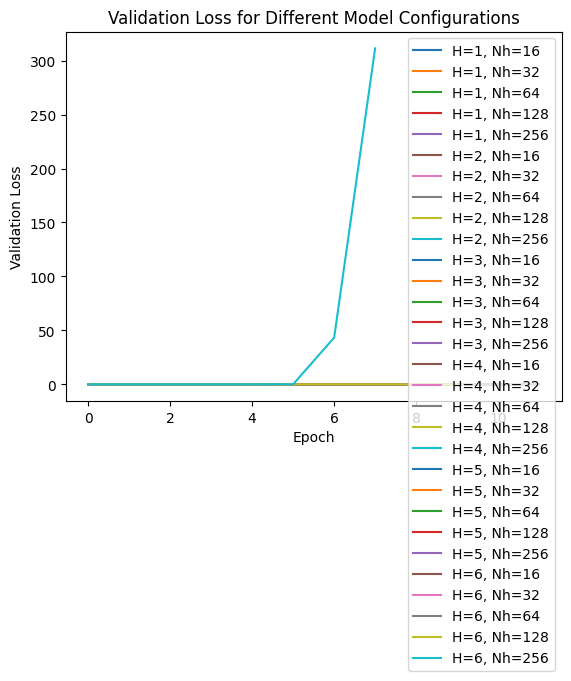

Model with H=1 and Nh=16:
MSE: 0.002957866992801428
MAE: 0.0029578677839017893
RMSE: 0.006965449572510246
R-squared: 0.9803946906492973
MAPE: 19.499692595455386%
Model with H=1 and Nh=32:
MSE: 0.003075558925047517
MAE: 0.0030755586505635366
RMSE: 0.00792807305781578
R-squared: 0.9746013471801032
MAPE: 19.02261733116356%
Model with H=1 and Nh=64:
MSE: 0.003695774357765913
MAE: 0.003695772855588552
RMSE: 0.0075480229295542154
R-squared: 0.9769780653845082
MAPE: 17.154365297936323%
Model with H=1 and Nh=128:
MSE: 0.0029545361176133156
MAE: 0.002954536412925363
RMSE: 0.006625191256764135
R-squared: 0.9822633239223286
MAPE: 17.279029463916473%
Model with H=1 and Nh=256:
MSE: 0.003581010503694415
MAE: 0.0035810107554731722
RMSE: 0.007667527672209681
R-squared: 0.9762433008118504
MAPE: 18.041437994908158%
Model with H=2 and Nh=16:
MSE: 0.003153729485347867
MAE: 0.0031537303490033097
RMSE: 0.008427604164457037
R-squared: 0.9712998839599305
MAPE: 13.461038414508527%
Model with H=2 and Nh=32:
MS

In [33]:

# Iterate over different values of H and Nh
for H in H_values:
    for Nh in Nh_values:
        # Initialize a Sequential model
        model_4 = tf.keras.Sequential()

        # Add the first hidden layer with batch normalization
        model_4.add(tf.keras.layers.Dense(Nh, activation='relu', input_shape=(4,)))  
        model_4.add(tf.keras.layers.BatchNormalization())

        # Add subsequent hidden layers with batch normalization
        for _ in range(H - 1):
            model_4.add(tf.keras.layers.Dense(Nh, activation='relu'))
            model_4.add(tf.keras.layers.BatchNormalization())

        # Output layer (assuming it follows the hidden layers)
        model_4.add(tf.keras.layers.Dense(1, activation='softplus'))  

        # Compile the model
        model_4.compile(optimizer='adam', loss='mean_absolute_error')

        # Train the model and store the training history
    # Train the model with given hyperparameters
        history_4 = model_4.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), 
                        callbacks=[PrintEpochInfo(), lr_scheduler, early_stopping], verbose=0)
    
        histories_4[(H, Nh)] = history_4

        # Evaluate the model on the testing set
        predictions_4 = model_4.predict(X_test)

        # Evaluate the model on the testing set and calculate MSE
        mse_4 = model_4.evaluate(X_test, y_test)
        mses_4[(H, Nh)] = mse_4

        # Calculate Mean Absolute Error (MAE)
        mae_4 = mean_absolute_error(y_test, predictions_4)
        maes_4[(H, Nh)] = mae_4

        # Calculate Root Mean Squared Error (RMSE)
        rmse_4 = np.sqrt(mean_squared_error(y_test, predictions_4))
        rmses_4[(H, Nh)] = rmse_4

        # Calculate R-squared (R2) Score
        r2_4 = r2_score(y_test, predictions_4)
        r2_scores_4[(H, Nh)] = r2_4

        # Calculate Mean Absolute Percentage Error (MAPE)
        mape_4 = np.mean(np.abs((y_test - predictions_4) / y_test)) * 100
        mapes_4[(H, Nh)] = mape_4

# Plot the validation loss for each configuration
for (H, Nh), history_4 in histories_4.items():
    plt.plot(history_4.history['val_loss'], label=f'H={H}, Nh={Nh}')

plt.title('Validation Loss for Different Model Configurations')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()

# Print the MSE for each configuration
# Print the evaluation metrics for each configuration
for (H, Nh), mse_4 in mses_4.items():
    print(f'Model with H={H} and Nh={Nh}:')
    print(f'MSE: {mse_4}')
    print(f'MAE: {maes_4[(H, Nh)]}')
    print(f'RMSE: {rmses_4[(H, Nh)]}')
    print(f'R-squared: {r2_scores_4[(H, Nh)]}')
    print(f'MAPE: {mapes_4[(H, Nh)]}%')


In [34]:
# Rank combinations based on their MSE values
ranked_combinations_4 = sorted(mses_4.items(), key=lambda x: x[1])

# Print ranked combinations
for idx, ((H, Nh), mse_4) in enumerate(ranked_combinations_4, start=1):
    print(f"Rank {idx}: Combination H={H}, Nh={Nh} - MSE: {mse_4}")


Rank 1: Combination H=2, Nh=128 - MSE: 0.0018751391908153892
Rank 2: Combination H=6, Nh=64 - MSE: 0.0019073612056672573
Rank 3: Combination H=5, Nh=16 - MSE: 0.0020969603210687637
Rank 4: Combination H=6, Nh=32 - MSE: 0.0021718479692935944
Rank 5: Combination H=3, Nh=256 - MSE: 0.0021965275518596172
Rank 6: Combination H=3, Nh=128 - MSE: 0.002227099845185876
Rank 7: Combination H=6, Nh=128 - MSE: 0.002312362426891923
Rank 8: Combination H=5, Nh=128 - MSE: 0.002345615765079856
Rank 9: Combination H=4, Nh=64 - MSE: 0.0024717464111745358
Rank 10: Combination H=5, Nh=32 - MSE: 0.002509501064196229
Rank 11: Combination H=5, Nh=64 - MSE: 0.0025410139933228493
Rank 12: Combination H=2, Nh=32 - MSE: 0.0025423644110560417
Rank 13: Combination H=3, Nh=64 - MSE: 0.0026077653747051954
Rank 14: Combination H=2, Nh=64 - MSE: 0.002647524932399392
Rank 15: Combination H=4, Nh=128 - MSE: 0.0027189026586711407
Rank 16: Combination H=4, Nh=16 - MSE: 0.0027267872355878353
Rank 17: Combination H=3, Nh=32 

In [37]:
# Specify the combination you want to call
H = 2
Nh = 128

# Retrieve the model for the specified combination
selected_model_4 = histories_4[(H, Nh)].model
selected_model_4.save("model_2_128_Plc.h5")
# Use the trained model to make predictions on the testing set
prediction_4 = selected_model_4.predict(X_test)

# Evaluate the model on the testing set
mse_4_4 = selected_model_4.evaluate(X_test, y_test)
print("Mean Squared Error on Testing Set:", mse_4_4)

# Print the first few predictions
print("Predictions:")
print(prediction_4[:5])

# Print the corresponding true values
print("True Values:")
print(y_test[:5])

185/750 [======>.......................] - ETA: 0s

d:\Software\Python\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


750/750 [==============================] - 0s 589us/step - loss: 0.9344
Mean Squared Error on Testing Set: 0.9343703389167786
Predictions:
[[0.07427406]
 [0.00535328]
 [0.05610719]
 [0.01520143]
 [0.01019582]]
True Values:
[[1.63623509]
 [0.46468755]
 [1.69007496]
 [1.10227304]
 [0.64733476]]


## Pl_L_Cu

In [36]:


# Fix random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load your simulation data
# Replace "your_dataset.csv" with the path to your dataset
# df = pd.read_csv(r"D:\Krishna\ai-power-converter\dataset\simulation_results_53x13x13x13.csv")
df_5 = pd.read_csv(r"D:\Krishna\ai-power-converter\simulation_results_new_20_20_20_20.csv")

# Extract input features (L, C, fsw)
X_5 = df_5[['L', 'C', 'fsw', "t_dt"]].values

# Extract output (ripples)
y_5 = df_5[["Pl_L_Cu"]].values  # Adjust column names as per your dataset

# Define custom scaling ranges for each input feature
L_min, L_max = 30e-6, 2000e-6
C_min, C_max = 20e-6, 1000e-6
fsw_min, fsw_max = 20e3, 200e3
t_dt_min, t_dt_max = 0.178e-6, 1e-6

X_scaled = custom_scaling(X)
print(X_scaled[90:])

# Split the dataset into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y_5, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Define a custom callback to print custom information at the end of each epoch
class PrintEpochInfo(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch+1}/{self.params['epochs']}, Loss: {logs['loss']}, Val Loss: {logs['val_loss']}")


# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=1, mode='auto', restore_best_weights=True)

# Define the learning rate scheduler
lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-6)# Initialize a dictionary to store the training history for each configuration


histories_5 = {}

# Initialize dictionaries to store the evaluation metrics for each configuration
mses_5 = {}
maes_5 = {}
rmses_5 = {}
r2_scores_5 = {}
mapes_5 = {}

# Define a list of different values for H and Nh to try
H_values = [1, 2, 3, 4, 5, 6]  # Number of hidden layers
Nh_values = [16, 32, 64, 128, 256]  # Number of neurons per hidden layer

[[0.         0.01020408 0.21052222 0.52676399]
 [0.         0.01020408 0.21052222 0.57907543]
 [0.         0.01020408 0.21052222 0.63138686]
 ...
 [1.         0.18367347 1.         0.89416058]
 [1.         0.18367347 1.         0.94768856]
 [1.         0.18367347 1.         1.        ]]


Epoch 1/100, Loss: 0.1481057107448578, Val Loss: 0.09116435796022415
Epoch 2/100, Loss: 0.13012023270130157, Val Loss: 0.09947912395000458
Epoch 3/100, Loss: 0.12528228759765625, Val Loss: 0.10144007205963135
Epoch 4/100, Loss: 0.12620244920253754, Val Loss: 0.08574450761079788
Epoch 5/100, Loss: 0.12582772970199585, Val Loss: 0.09282246977090836
Epoch 6/100, Loss: 0.12612366676330566, Val Loss: 0.08619622141122818
Epoch 7/100, Loss: 0.12630456686019897, Val Loss: 0.0867219939827919
Epoch 8/100, Loss: 0.12414395064115524, Val Loss: 0.08751776814460754
Epoch 9/100, Loss: 0.12479978054761887, Val Loss: 0.08485235273838043
Restoring model weights from the end of the best epoch: 4.
Epoch 9: early stopping
750/750 [==============================] - 1s 954us/step - loss: 0.0864
Epoch 1/100, Loss: 0.13283608853816986, Val Loss: 0.07975370436906815
Epoch 2/100, Loss: 0.11706575006246567, Val Loss: 0.07151582837104797
Epoch 3/100, Loss: 0.10874660313129425, Val Loss: 0.07056360691785812
Epoch 4

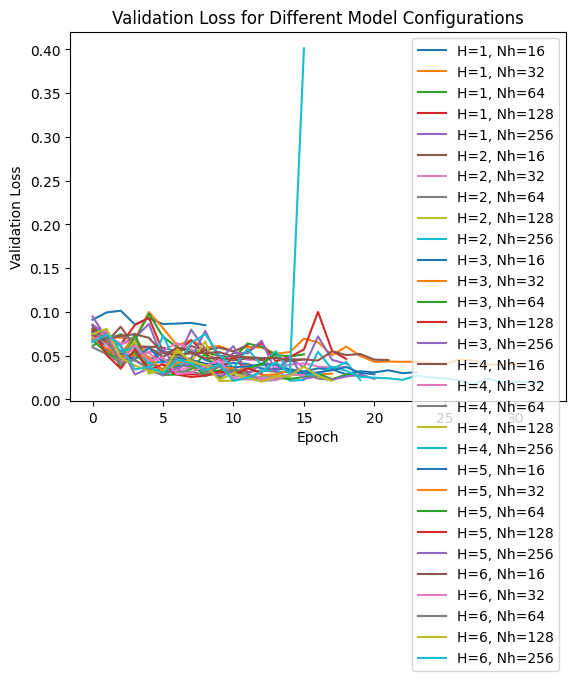

Model with H=1 and Nh=16:
MSE: 0.08636287599802017
MAE: 0.08636283735396152
RMSE: 0.14359723163066154
R-squared: 0.9339478912460281
MAPE: 12.464817546116754%
Model with H=1 and Nh=32:
MSE: 0.0407460518181324
MAE: 0.040746065584235394
RMSE: 0.056137937078299414
R-squared: 0.9899049737770274
MAPE: 6.286124411276216%
Model with H=1 and Nh=64:
MSE: 0.04721140116453171
MAE: 0.047211408016978054
RMSE: 0.06524332270147633
R-squared: 0.9863646373261273
MAPE: 6.960545828860594%
Model with H=1 and Nh=128:
MSE: 0.04358735680580139
MAE: 0.04358734624545746
RMSE: 0.061379994159828734
R-squared: 0.9879316405166845
MAPE: 6.302529359825737%
Model with H=1 and Nh=256:
MSE: 0.03178558498620987
MAE: 0.031785590658662564
RMSE: 0.04604957986218252
R-squared: 0.993207245841073
MAPE: 4.409146384186545%
Model with H=2 and Nh=16:
MSE: 0.05555398389697075
MAE: 0.05555401400609572
RMSE: 0.07744184449240947
R-squared: 0.9807891788282921
MAPE: 9.472331979157996%
Model with H=2 and Nh=32:
MSE: 0.03677818551659584
M

In [39]:

# Iterate over different values of H and Nh
for H in H_values:
    for Nh in Nh_values:
        # Initialize a Sequential model
        model_5 = tf.keras.Sequential()

        # Add the first hidden layer with batch normalization
        model_5.add(tf.keras.layers.Dense(Nh, activation='relu', input_shape=(4,)))  
        model_5.add(tf.keras.layers.BatchNormalization())

        # Add subsequent hidden layers with batch normalization
        for _ in range(H - 1):
            model_5.add(tf.keras.layers.Dense(Nh, activation='relu'))
            model_5.add(tf.keras.layers.BatchNormalization())

        # Output layer (assuming it follows the hidden layers)
        model_5.add(tf.keras.layers.Dense(1, activation='softplus'))  

        # Compile the model
        model_5.compile(optimizer='adam', loss='mean_absolute_error')

        # Train the model and store the training history
    # Train the model with given hyperparameters
        history_5 = model_5.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), 
                        callbacks=[PrintEpochInfo(), lr_scheduler, early_stopping], verbose=0)
    
        histories_5[(H, Nh)] = history_5

        # Evaluate the model on the testing set
        predictions_5 = model_5.predict(X_test)

        # Evaluate the model on the testing set and calculate MSE
        mse_5 = model_5.evaluate(X_test, y_test)
        mses_5[(H, Nh)] = mse_5

        # Calculate Mean Absolute Error (MAE)
        mae_5 = mean_absolute_error(y_test, predictions_5)
        maes_5[(H, Nh)] = mae_5

        # Calculate Root Mean Squared Error (RMSE)
        rmse_5 = np.sqrt(mean_squared_error(y_test, predictions_5))
        rmses_5[(H, Nh)] = rmse_5

        # Calculate R-squared (R2) Score
        r2_5 = r2_score(y_test, predictions_5)
        r2_scores_5[(H, Nh)] = r2_5

        # Calculate Mean Absolute Percentage Error (MAPE)
        mape_5 = np.mean(np.abs((y_test - predictions_5) / y_test)) * 100
        mapes_5[(H, Nh)] = mape_5

# Plot the validation loss for each configuration
for (H, Nh), history_5 in histories_5.items():
    plt.plot(history_5.history['val_loss'], label=f'H={H}, Nh={Nh}')

plt.title('Validation Loss for Different Model Configurations')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()

# Print the MSE for each configuration
# Print the evaluation metrics for each configuration
for (H, Nh), mse_5 in mses_5.items():
    print(f'Model with H={H} and Nh={Nh}:')
    print(f'MSE: {mse_5}')
    print(f'MAE: {maes_5[(H, Nh)]}')
    print(f'RMSE: {rmses_5[(H, Nh)]}')
    print(f'R-squared: {r2_scores_5[(H, Nh)]}')
    print(f'MAPE: {mapes_5[(H, Nh)]}%')


In [40]:
# Rank combinations based on their MSE values
ranked_combinations_5 = sorted(mses_5.items(), key=lambda x: x[1])

# Print ranked combinations
for idx, ((H, Nh), mse_5) in enumerate(ranked_combinations_5, start=1):
    print(f"Rank {idx}: Combination H={H}, Nh={Nh} - MSE: {mse_5}")


Rank 1: Combination H=4, Nh=256 - MSE: 0.017062567174434662
Rank 2: Combination H=6, Nh=128 - MSE: 0.02008994109928608
Rank 3: Combination H=2, Nh=128 - MSE: 0.021010784432291985
Rank 4: Combination H=6, Nh=256 - MSE: 0.021167371422052383
Rank 5: Combination H=4, Nh=64 - MSE: 0.021297479048371315
Rank 6: Combination H=2, Nh=256 - MSE: 0.02139408327639103
Rank 7: Combination H=6, Nh=32 - MSE: 0.023357674479484558
Rank 8: Combination H=3, Nh=256 - MSE: 0.02350023202598095
Rank 9: Combination H=3, Nh=64 - MSE: 0.023517483845353127
Rank 10: Combination H=4, Nh=32 - MSE: 0.025204721838235855
Rank 11: Combination H=5, Nh=128 - MSE: 0.02583681419491768
Rank 12: Combination H=5, Nh=256 - MSE: 0.027304865419864655
Rank 13: Combination H=3, Nh=32 - MSE: 0.027347855269908905
Rank 14: Combination H=5, Nh=64 - MSE: 0.02818407490849495
Rank 15: Combination H=3, Nh=16 - MSE: 0.028857268393039703
Rank 16: Combination H=3, Nh=128 - MSE: 0.029180053621530533
Rank 17: Combination H=6, Nh=64 - MSE: 0.0292

In [41]:
# Specify the combination you want to call
H = 4
Nh = 256

# Retrieve the model for the specified combination
selected_model_5 = histories_5[(H, Nh)].model
selected_model_5.save("model_4_256_Pllcu.h5")
# Use the trained model to make predictions on the testing set
prediction_5 = selected_model_5.predict(X_test)

# Evaluate the model on the testing set
mse_5_5 = selected_model_5.evaluate(X_test, y_test)
print("Mean Squared Error on Testing Set:", mse_5_5)

# Print the first few predictions
print("Predictions:")
print(prediction_5[:5])

# Print the corresponding true values
print("True Values:")
print(y_test[:5])

144/750 [====>.........................] - ETA: 0s

d:\Software\Python\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


750/750 [==============================] - 1s 716us/step - loss: 0.0171
Mean Squared Error on Testing Set: 0.017062567174434662
Predictions:
[[1.6104228 ]
 [0.48125488]
 [1.6784889 ]
 [1.0803841 ]
 [0.6550206 ]]
True Values:
[[1.63623509]
 [0.46468755]
 [1.69007496]
 [1.10227304]
 [0.64733476]]


## P_D

In [42]:


# Fix random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load your simulation data
# Replace "your_dataset.csv" with the path to your dataset
# df = pd.read_csv(r"D:\Krishna\ai-power-converter\dataset\simulation_results_63x13x13x13.csv")
df_6 = pd.read_csv(r"D:\Krishna\ai-power-converter\simulation_results_new_20_20_20_20.csv")

# Extract input features (L, C, fsw)
X_6 = df_6[['L', 'C', 'fsw', "t_dt"]].values

# Extract output (ripples)
y_6 = df_6[["P_D"]].values  # Adjust column names as per your dataset

# Define custom scaling ranges for each input feature
L_min, L_max = 30e-6, 2000e-6
C_min, C_max = 20e-6, 1000e-6
fsw_min, fsw_max = 20e3, 200e3
t_dt_min, t_dt_max = 0.178e-6, 1e-6

X_scaled = custom_scaling(X)
print(X_scaled[90:])

# Split the dataset into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y_6, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Define a custom callback to print custom information at the end of each epoch
class PrintEpochInfo(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch+1}/{self.params['epochs']}, Loss: {logs['loss']}, Val Loss: {logs['val_loss']}")


# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=1, mode='auto', restore_best_weights=True)

# Define the learning rate scheduler
lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-6)# Initialize a dictionary to store the training history for each configuration


histories_6 = {}

# Initialize dictionaries to store the evaluation metrics for each configuration
mses_6 = {}
maes_6 = {}
rmses_6 = {}
r2_scores_6 = {}
mapes_6 = {}

# Define a list of different values for H and Nh to try
H_values = [1, 2, 3, 4, 5, 6]  # Number of hidden layers
Nh_values = [16, 32, 64, 128, 256]  # Number of neurons per hidden layer

[[0.         0.01020408 0.21052222 0.52676399]
 [0.         0.01020408 0.21052222 0.57907543]
 [0.         0.01020408 0.21052222 0.63138686]
 ...
 [1.         0.18367347 1.         0.89416058]
 [1.         0.18367347 1.         0.94768856]
 [1.         0.18367347 1.         1.        ]]


Epoch 1/100, Loss: 0.03201694041490555, Val Loss: 0.008000497706234455
Epoch 2/100, Loss: 0.009400750510394573, Val Loss: 0.00728748319670558
Epoch 3/100, Loss: 0.009167523123323917, Val Loss: 0.006144230719655752
Epoch 4/100, Loss: 0.009160558693110943, Val Loss: 0.0063473740592598915
Epoch 5/100, Loss: 0.009180550463497639, Val Loss: 0.008392734453082085
Epoch 6/100, Loss: 0.009165571071207523, Val Loss: 0.00617337878793478
Epoch 7/100, Loss: 0.008939752355217934, Val Loss: 0.005930437706410885
Epoch 8/100, Loss: 0.008936138823628426, Val Loss: 0.007435829844325781
Restoring model weights from the end of the best epoch: 3.
Epoch 8: early stopping
750/750 [==============================] - 0s 496us/step - loss: 0.0061
Epoch 1/100, Loss: 0.0238367710262537, Val Loss: 0.005272712092846632
Epoch 2/100, Loss: 0.008193785324692726, Val Loss: 0.0038743391633033752
Epoch 3/100, Loss: 0.007843180559575558, Val Loss: 0.008139372803270817
Epoch 4/100, Loss: 0.007784936111420393, Val Loss: 0.003

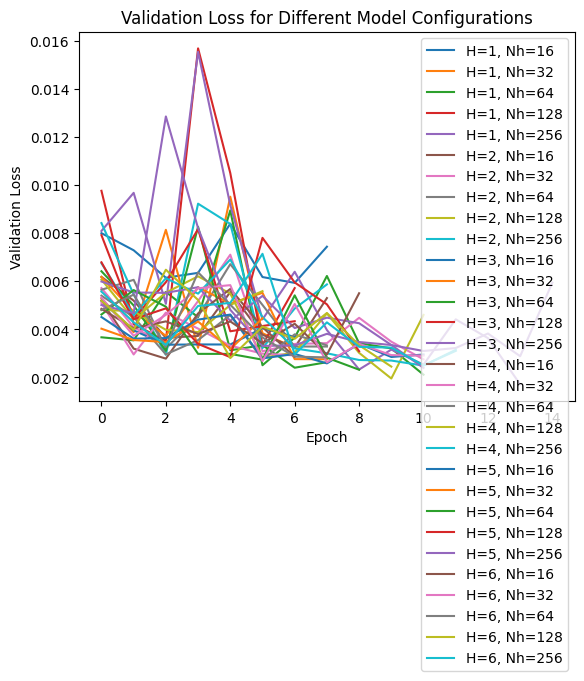

Model with H=1 and Nh=16:
MSE: 0.0060764700174331665
MAE: 0.006076469434744901
RMSE: 0.008231854196504655
R-squared: 0.9562796367045968
MAPE: 9.175053339807526%
Model with H=1 and Nh=32:
MSE: 0.00381755200214684
MAE: 0.003817550772587956
RMSE: 0.00530723167454349
R-squared: 0.9818270883489945
MAPE: 5.0873669903625895%
Model with H=1 and Nh=64:
MSE: 0.0024960271548479795
MAE: 0.0024960282428314238
RMSE: 0.003227045405210602
R-squared: 0.9932810938467834
MAPE: 4.233860298452848%
Model with H=1 and Nh=128:
MSE: 0.004183854907751083
MAE: 0.004183854526673552
RMSE: 0.005438152708485131
R-squared: 0.9809194354374906
MAPE: 6.111687024370271%
Model with H=1 and Nh=256:
MSE: 0.0022864590864628553
MAE: 0.002286458453427471
RMSE: 0.0031398662785069933
R-squared: 0.9936392148257179
MAPE: 4.341369402125771%
Model with H=2 and Nh=16:
MSE: 0.0035523639526218176
MAE: 0.003552362194264513
RMSE: 0.004981468876613703
R-squared: 0.9839895600699528
MAPE: 4.792111022125273%
Model with H=2 and Nh=32:
MSE: 0.

In [43]:

# Iterate over different values of H and Nh
for H in H_values:
    for Nh in Nh_values:
        # Initialize a Sequential model
        model_6 = tf.keras.Sequential()

        # Add the first hidden layer with batch normalization
        model_6.add(tf.keras.layers.Dense(Nh, activation='relu', input_shape=(4,)))  
        model_6.add(tf.keras.layers.BatchNormalization())

        # Add subsequent hidden layers with batch normalization
        for _ in range(H - 1):
            model_6.add(tf.keras.layers.Dense(Nh, activation='relu'))
            model_6.add(tf.keras.layers.BatchNormalization())

        # Output layer (assuming it follows the hidden layers)
        model_6.add(tf.keras.layers.Dense(1, activation='softplus'))  

        # Compile the model
        model_6.compile(optimizer='adam', loss='mean_absolute_error')

        # Train the model and store the training history
    # Train the model with given hyperparameters
        history_6 = model_6.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), 
                        callbacks=[PrintEpochInfo(), lr_scheduler, early_stopping], verbose=0)
    
        histories_6[(H, Nh)] = history_6

        # Evaluate the model on the testing set
        predictions_6 = model_6.predict(X_test)

        # Evaluate the model on the testing set and calculate MSE
        mse_6 = model_6.evaluate(X_test, y_test)
        mses_6[(H, Nh)] = mse_6

        # Calculate Mean Absolute Error (MAE)
        mae_6 = mean_absolute_error(y_test, predictions_6)
        maes_6[(H, Nh)] = mae_6

        # Calculate Root Mean Squared Error (RMSE)
        rmse_6 = np.sqrt(mean_squared_error(y_test, predictions_6))
        rmses_6[(H, Nh)] = rmse_6

        # Calculate R-squared (R2) Score
        r2_6 = r2_score(y_test, predictions_6)
        r2_scores_6[(H, Nh)] = r2_6

        # Calculate Mean Absolute Percentage Error (MAPE)
        mape_6 = np.mean(np.abs((y_test - predictions_6) / y_test)) * 100
        mapes_6[(H, Nh)] = mape_6

# Plot the validation loss for each configuration
for (H, Nh), history_6 in histories_6.items():
    plt.plot(history_6.history['val_loss'], label=f'H={H}, Nh={Nh}')

plt.title('Validation Loss for Different Model Configurations')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()

# Print the MSE for each configuration
# Print the evaluation metrics for each configuration
for (H, Nh), mse_6 in mses_6.items():
    print(f'Model with H={H} and Nh={Nh}:')
    print(f'MSE: {mse_6}')
    print(f'MAE: {maes_6[(H, Nh)]}')
    print(f'RMSE: {rmses_6[(H, Nh)]}')
    print(f'R-squared: {r2_scores_6[(H, Nh)]}')
    print(f'MAPE: {mapes_6[(H, Nh)]}%')


In [46]:
# Rank combinations based on their MSE values
ranked_combinations_6 = sorted(mses_6.items(), key=lambda x: x[1])

# Print ranked combinations
for idx, ((H, Nh), mse_6) in enumerate(ranked_combinations_6, start=1):
    print(f"Rank {idx}: Combination H={H}, Nh={Nh} - MSE: {mse_6}")


Rank 1: Combination H=1, Nh=256 - MSE: 0.0022864590864628553
Rank 2: Combination H=1, Nh=64 - MSE: 0.0024960271548479795
Rank 3: Combination H=6, Nh=32 - MSE: 0.0026410333812236786
Rank 4: Combination H=5, Nh=16 - MSE: 0.0027565425261855125
Rank 5: Combination H=2, Nh=128 - MSE: 0.0027624887879937887
Rank 6: Combination H=6, Nh=128 - MSE: 0.002770878141745925
Rank 7: Combination H=6, Nh=256 - MSE: 0.002908228663727641
Rank 8: Combination H=4, Nh=32 - MSE: 0.002908672671765089
Rank 9: Combination H=2, Nh=256 - MSE: 0.002937649143859744
Rank 10: Combination H=4, Nh=64 - MSE: 0.002944887848570943
Rank 11: Combination H=5, Nh=64 - MSE: 0.0029506010469049215
Rank 12: Combination H=2, Nh=32 - MSE: 0.003049223916605115
Rank 13: Combination H=4, Nh=16 - MSE: 0.0031143855303525925
Rank 14: Combination H=3, Nh=64 - MSE: 0.0031179110519587994
Rank 15: Combination H=2, Nh=64 - MSE: 0.00315296882763505
Rank 16: Combination H=6, Nh=64 - MSE: 0.0032342507038265467
Rank 17: Combination H=4, Nh=256 - M

In [47]:
# Specify the combination you want to call
H = 1
Nh = 256

# Retrieve the model for the specified combination
selected_model_6 = histories_6[(H, Nh)].model
selected_model_6.save("model_1_256_pd.h5")
# Use the trained model to make predictions on the testing set
prediction_6 = selected_model_6.predict(X_test)

# Evaluate the model on the testing set
mse_6_6 = selected_model_6.evaluate(X_test, y_test)
print("Mean Squared Error on Testing Set:", mse_6_6)

# Print the first few predictions
print("Predictions:")
print(prediction_6[:5])

# Print the corresponding true values
print("True Values:")
print(y_test[:5])

298/750 [==========>...................] - ETA: 0s

d:\Software\Python\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


750/750 [==============================] - 0s 503us/step - loss: 0.0023
Mean Squared Error on Testing Set: 0.0022864590864628553
Predictions:
[[0.0659787 ]
 [0.13348639]
 [0.05833554]
 [0.05207297]
 [0.10763238]]
True Values:
[[0.06506221]
 [0.13715643]
 [0.05960087]
 [0.05289084]
 [0.10150244]]
